Wi-fi CSI Human body movements pattern recognition using CNN classifier
There are 4 classes of motion, the aim is train the model to learn to identify the motion pattern based on the spectra .png files that were obtained by converting the csi files recived via rasberry pi. 
The image format is 64x1000 px , resolution 72 dpi, bit depth 24

In [64]:
import os
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical


In [63]:
#Folder Structure
DATA_DIR = "C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train"

print("Body_Movements_Train")
for folder_name in sorted(os.listdir(DATA_DIR)):
    folder_path = os.path.join(DATA_DIR, folder_name)
    if os.path.isdir(folder_path):
        png_count = len([f for f in os.listdir(folder_path) if f.endswith('.png')])
        print(f"├── {folder_name} [{png_count} .png files]")


Body_Movements_Train
├── nothing [96 .png files]
├── sitting [290 .png files]
├── squat [240 .png files]
├── standing [290 .png files]
├── walk [288 .png files]


In [65]:
DATA_DIR = "C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train"

# Go through each action folder
for action_folder in os.listdir(DATA_DIR):
    action_path = os.path.join(DATA_DIR, action_folder)
    
    if not os.path.isdir(action_path):
        print(f"Skipping {action_path}, not a directory.")
        continue

    index = 0
    for filename in os.listdir(action_path):
        if filename.endswith(".png"):
            # Skip already renamed files (e.g., walk_0.png)
            if re.match(rf"^{re.escape(action_folder)}_\d+\.png$", filename):
                print(f"Already renamed, skipping: {filename}")
                continue

            # Match only original files like walk-100_clean.png
            match = re.search(r"[-_](\d+)_clean\.png$", filename)
            if not match:
                print(f"Unrecognized format, skipping: {filename}")
                continue

            new_name = f"{action_folder}_{index}.png"
            old_path = os.path.join(action_path, filename)
            new_path = os.path.join(action_path, new_name)

            # Avoid overwriting
            if os.path.exists(new_path):
                print(f"File already exists, skipping: {new_path}")
                index += 1  # Still increment to avoid collisions
                continue

            os.rename(old_path, new_path)
            print(f"Renamed {filename} to {new_name}")
            index += 1

print("Renaming complete.")

Already renamed, skipping: nothing_0.png
Already renamed, skipping: nothing_1.png
Already renamed, skipping: nothing_10.png
Already renamed, skipping: nothing_11.png
Already renamed, skipping: nothing_12.png
Already renamed, skipping: nothing_13.png
Already renamed, skipping: nothing_14.png
Already renamed, skipping: nothing_15.png
Already renamed, skipping: nothing_16.png
Already renamed, skipping: nothing_17.png
Already renamed, skipping: nothing_18.png
Already renamed, skipping: nothing_19.png
Already renamed, skipping: nothing_2.png
Already renamed, skipping: nothing_20.png
Already renamed, skipping: nothing_21.png
Already renamed, skipping: nothing_22.png
Already renamed, skipping: nothing_23.png
Already renamed, skipping: nothing_24.png
Already renamed, skipping: nothing_25.png
Already renamed, skipping: nothing_26.png
Already renamed, skipping: nothing_27.png
Already renamed, skipping: nothing_28.png
Already renamed, skipping: nothing_29.png
Already renamed, skipping: nothing_3.

The data used for training consits of 5 catgories: 
walking: 288
standing: 290
squat:240 
sitting:290
no_movement: 96


folder:C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train\nothing
Train: X=(963, 1000, 64, 3), y=(963, 5)
Test: X=(241, 1000, 64, 3), y=(241, 5)


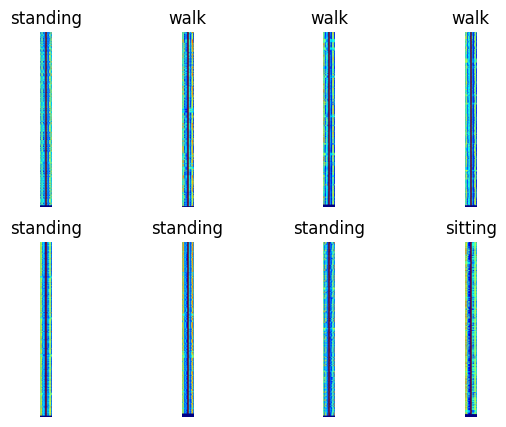

In [67]:
# Path to dataset folder containing subfolders

IMG_SIZE = (64, 1000)  # Resize images to a consistent shape

# Map class names to indices
class_names = ['walk', 'standing', 'squat', 'sitting', 'nothing']
class_indices = {name: i for i, name in enumerate(class_names)}


# Load all images and labels
X, y = [], []
for class_name in class_names:
    folder = os.path.join(DATA_DIR, class_name)
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            image = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
            X.append(np.array(image))
            y.append(class_indices[class_name])


X = np.array(X)
y = np.array(y)
print(f"folder:{folder}")

# Split dataset
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Normalize the data
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0


# One-hot encode labels
trainy = to_categorical(trainy, num_classes=5)
testy = to_categorical(testy, num_classes=5)


# Print shape summary
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# Plot first few images
cols = 4
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X[random_index, :])
        true_label = class_names[y[random_index]]
        ax.set_title("{}".format(true_label))
plt.show()

#Test for a weird image 
# image_path = "C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train/nothing/nothing-100_clean.png"
# img = Image.open(image_path).convert("RGB").resize((64, 1000))

# plt.figure(figsize=(10, 3))
# plt.imshow(img)
# plt.axis("off")
# plt.title("nothing-100_clean.png")
# plt.show()


The architecture is the a hybrid simplified ResNet. This can be further imporved by adding lightweight bottlenecks 

In [70]:

# define CNN model

def build_csi_classifier(input_shape=(64, 1000, 3), num_classes=5):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 3
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 4
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)

    # Classification head
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



For this model.fit(trainGen)-> Use ImageDataGenerator + .flow_from_directory(), In case we decide to use transfer learning and real-time data augmentation this is useful

In [77]:
#Build the model and see summary 
#Note: those 960 non-trainable parameters come from the BatchNormalization layers, indeed we are using all weight to train 
#The non-trainable parameters include moving averages (moving_mean, moving_variance) used during inference (not updated by gradients)

model = build_csi_classifier(input_shape=(1000,64, 3), num_classes=5) #1000, 64, 3
model.summary()  # Optional: visualize the layer stack


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1000, 64, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 1000, 64, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1000, 64, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 1000, 64, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 500, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 500, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 500, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 500, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 250, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 250, 16, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 250, 16, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 250, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 125, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 8, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 125, 8, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 125, 8, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,877 (1.62 MB)

 Trainable params: 422,917 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [78]:
#compile the model 
model = build_csi_classifier(input_shape=(1000, 64, 3), num_classes=5) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
#train the model and save it 
history = model.fit(
    trainX, trainy,
    validation_data=(testX, testy),
    epochs=3,
    batch_size=22, #Kepp it slightly low 22 seems fine for now 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

# Valditation accuracy is not changing, reasons: 
# Not equally distributed number of images per class 
# learning rate is too high/low
# maybe another optimizer would work better
# batch size, is it too high, too low ? 


#A good method for debugging this issue is to use an ipython/jupyter notebook, compile the model, and then have it predict for one of your batches. Then, go through the accuracy code with the ability to manually inspect the values of the matrices. 
# I've found stepping through code like this in mysterious situations to be enlightening.
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)??? might work

Epoch 1/3
44/44 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7902 - loss: 0.5752 - val_accuracy: 0.2407 - val_loss: 5.0529 - learning_rate: 0.0010
Epoch 2/3
44/44 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8935 - loss: 0.2935 - val_accuracy: 0.2407 - val_loss: 8.9985 - learning_rate: 0.0010
Epoch 3/3
44/44 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9475 - loss: 0.1675 - val_accuracy: 0.2407 - val_loss: 11.8907 - learning_rate: 0.0010


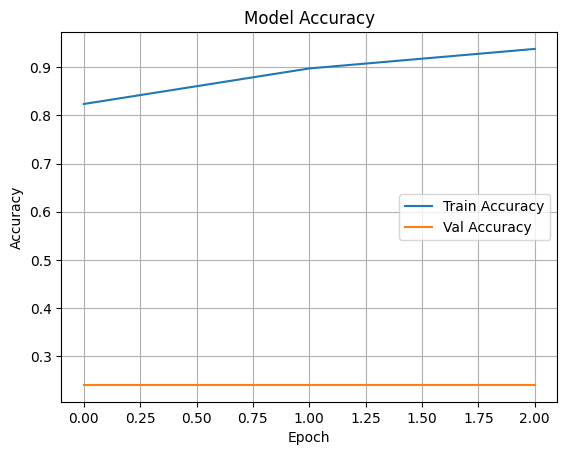

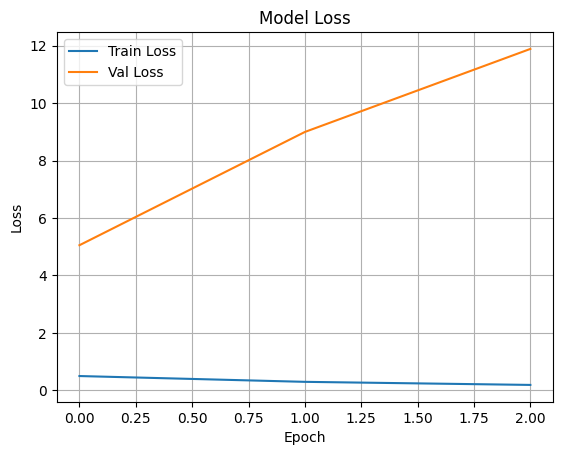

In [82]:
#

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
